In [1]:
# imports
import os, os.path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import glob
import matplotlib.pyplot as plt
import typing as t
import math
import pickle

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Defining the Dataset

In [2]:
class SingleLanguageNameDataset(Dataset):
    """Dataset of names of a single language; upon loading, all the names are lowercased"""

    def __init__(self, name_dir: str, language: str = "English"):
        """
        :param name_dir: the path to the directory containing the name files
        :param language: the language of the names (with a capital letter at the begining)
        """
        self.name_dir = name_dir
        self.language = language
        
        self.language_file = os.path.join(self.name_dir, self.language + ".txt")
        self.language_file_length = None
        
    def __len__(self) -> int:
        # Lazy length loader
        if self.language_file_length is None:
            with open(self.language_file, 'r', encoding='utf8') as f:
                # store the number of lines excluding empty lines at the end
                self.language_file_length = len(f.read().rstrip().split('\n'))
        return self.language_file_length

    def __getitem__(self, index: int) -> str:
        assert index <= len(self), f"Index '{index}' not found in file '{self.language_file}' of length {len(self)}"

        with open(self.language_file, 'r', encoding='utf8') as f:
            # go through the file in a lazy way untill we get the target line
            for line_number, line in enumerate(f):
                if line_number == index:
                    return self.language + '|' + line.strip().lower()
        
        # if we don't find the index even after going through the file, it means we have a huge anomaly
        # combined with the assetr statement, this error should never be raised
        raise IndexError(f"Index '{index}' not found in file '{self.language_file}' of length {len(self)}")
    
    def __str__(self) -> str:
        return f"{self.__class__.__name__} object of {self.language} names; bound to file '{self.language_file}' of length {len(self)}"

In [3]:
class MultiLanguageNameDataset(ConcatDataset):
    def __init__(self, name_dir: str, languages: t.Optional[t.Iterable[str]] = None):
        """
        relies on multiple SingleLanguageNameDataset, one per possible language
        :param name_dir: the path to the directory containing the name files,
        :param languages: an iterable of the languages of the names (with a capital letter at the begining)
            or None to take all the languages available
        """
        # if the languages is None, we take all the languages available in the folder
        if languages is None: languages = self.find_languages(name_dir)

        self.languages = languages

        # create one single language dataset per language, and use them to create the multi-language dataset
        super().__init__(
            [SingleLanguageNameDataset(name_dir, language) for language in self.languages]
        )

    def find_languages(self, directory: str, extension: str='.txt') -> t.Iterable[str]:
        """Finds all files with the extension, and use those files to create a list of available languages."""
        # gather all the files in the directory
        files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

        languages = [language for language, ext in 
            [os.path.splitext(f) for f in files] # split into language name and extension
             if ext == extension] # filter by extension
        return languages

    def __str__(self) -> str:
        return f"{self.__class__.__name__} object of a total of {len(self)} names from the following languages:\n{self.languages}"

In [4]:
# testing the class
dataset = SingleLanguageNameDataset("corpus_names/names", 'English')
multi_dataset = MultiLanguageNameDataset("corpus_names/names")
str(dataset), dataset[5], str(multi_dataset), multi_dataset[5]

("SingleLanguageNameDataset object of English names; bound to file 'corpus_names/names\\English.txt' of length 3668",
 'English|abraham',
 "MultiLanguageNameDataset object of a total of 20074 names from the following languages:\n['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']",
 'Arabic|maalouf')

## Defining the Dataloader

### Collate function

In [5]:
class NameCollate(object):
    """Function object used as a collate function for DataLoader.
    
    Contains all the methods to build a chatacter-based encoding,
    add a start symbol at the start and an end symbol at the end of every sample,
    and apply padding and tensorisation to the batches
    """ 
    
    char_to_id: dict
    id_to_char: t.List[int]
    unk: str  # the replacement for unknown characters
    start: str  # the start symbol
    end: str  # the end symbol
    pad: str  # the padding value

    def __init__(self, unk: str="<UNK>", start: str="<START>", end: str="<END>", pad: str=" "):
        """
        :param unk: str, the replacement symbol for unknown characters
        :param start: str, the start symbol
        :param end: str, the end symbol
        :param pad: str, the padding symbol
        """
        self.unk, self.unk_id = unk, 0
        self.start, self.start_id = start, 1
        self.end, self.end_id = end, 2
        self.pad, self.pad_id = pad, 3
        self.first_unreserved_value = 4  # value to add to the character index to avoid overlap with reserved values
        self.char_to_id = self.id_to_char = None # untrained character to index mapping

    def _collate_fn(self, batch: t.Iterable[str]) -> torch.LongTensor:
        # transform the input into numbers
        batch = [self.char_to_tensor(sample) for sample in batch]
        
        # crop and add padding
        batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=self.pad_id)
        
        return batch

    def __call__(self, batch: t.Iterable[str]) -> torch.LongTensor:
        return self._collate_fn(batch)
                
    def char_to_tensor(self, string: str) -> torch.LongTensor:
        # transforms the string itself
        if self.char_to_id is None:
            index_list = [ord(char) + self.first_unreserved_value for char in string]
        else:
            index_list = [self.char_to_id.get(char, self.unk_id - self.first_unreserved_value) + self.first_unreserved_value for char in string]

        # add the start and end symbols
        index_list = [self.start_id] + index_list + [self.end_id]
        return torch.LongTensor(index_list)

    def tensor_to_char(self, tensor: torch.LongTensor, keep_special_tokens: bool=True) -> str:
        indexes = (int(index) for index in tensor.flatten()) # index generator
        return ''.join(self.int_to_char(index, keep_special_tokens=keep_special_tokens) for index in indexes)
        
    def int_to_char(self, index: int, keep_special_tokens: bool=True) -> str:
        # start and end symbol, padding symbol
        if index == self.start_id: return self.start if keep_special_tokens else '' 
        elif index == self.end_id: return self.end if keep_special_tokens else '' 
        elif index == self.pad_id: return self.pad if keep_special_tokens else '' 
        
        # transform either using the id_to_char mapping or the chr encoding
        elif self.id_to_char is None: return chr(index - self.first_unreserved_value)
        elif len(self.id_to_char) > index - self.first_unreserved_value >= 0: return self.id_to_char[int(index - self.first_unreserved_value)]
        
        # fallback on the unknown symbol
        else: return self.unk

    def train_char_mapping(self, dataset, max_chars: int=0) -> None:
        """Load all the characters in the data to build the character to integer mapping.
        If max_chars is strictly higher than 0, the vocabulary will be limited to the max_chars most frequent characters.
        If training is not done, ord() and chr() will be used to encode and decodde the characters.
        """
        if max_chars > 0:
            counter = Counter()
            for sample in dataset:
                counter.update(sample)

            self.id_to_char = [char for char, count in counter.most_commonon(max_chars)]
        else:
            self.id_to_char = list(set(char for sample in dataset for char in sample))
        self.char_to_id = {char: index for index, char in enumerate(self.id_to_char)}
        
    def get_voc_size(self) -> int:
        """Returns the size of the vocabulary, including the unkown, padding, start and stop tokens"""
        # according to https://www.programiz.com/python-programming/methods/built-in/chr, chr() maps 1114112 characters
        # that's why it's better to use a trained mapping in our case
        
        # size of the character mapping itself
        mapping_size = 1114112 if self.id_to_char is None else len(self.id_to_char)
        
        return mapping_size + 4  # +1 for each of the unkown, padding, start and stop token, so +4

## Hyperparameters & training parameters

### Defining default files

In [6]:
name_folder = "corpus_names/names"
dataset = MultiLanguageNameDataset(name_folder)
#dataset = SingleLanguageNameDataset(name_folder, "French")
# ratio of the dataset used for developement and evaluation, the remainder being allocated to training 
eval_ratio, dev_ratio = 0.1, 0.1  

### Train, dev, eval split

In [7]:
# size of each subset
eval_split = int(len(dataset) * eval_ratio)
dev_split = int(len(dataset) * dev_ratio)
train_split = len(dataset) - dev_split - eval_split

# random split into each subset
train_dataset, dev_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_split, dev_split, eval_split])
train_dataset, dev_dataset, eval_dataset

(<torch.utils.data.dataset.Subset at 0x2b0033eda20>,
 <torch.utils.data.dataset.Subset at 0x2b0033eda90>)

### Dataloader

In [8]:
batch_size = 128
num_workers = 0#4

# create the collate object and train the character mapping on the whole dataset
noun_collate = NameCollate()
noun_collate.train_char_mapping(dataset)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers,
                             collate_fn=noun_collate, pin_memory=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers,
                             collate_fn=noun_collate, pin_memory=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers,
                             collate_fn=noun_collate, pin_memory=True)

dataset_loaders = {"train": train_dataloader, "dev": dev_dataloader, "eval": eval_dataloader}
mode_method = {"train": lambda model: model.train(), "dev": lambda model: model.eval(), "eval": lambda model: model.eval()}

In [9]:
# save the collate function and the data split for later use
with open("dataset.pkl", "wb") as f:
    pickle.dump({
            'full': dataset,
            'train': train_dataset,
            'dev': dev_dataset,
            'eval': eval_dataset
        }, f)
with open("noun_collate.pkl", "wb") as f:
    pickle.dump(noun_collate, f)


### Training hyperparameters

In [10]:
epochs = 600
log_step_batch = 200
log_step_epoch = 10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss(ignore_index=noun_collate.pad_id)  # CrossEntropyLoss ignoring padding
optimizer_class = torch.optim.Adam#SGD

checkpoint_file_path = "model.state_dict.tch"

### Model hyperparameters

In [11]:
vocabulary_size = noun_collate.get_voc_size()  # size of the vocabulary, including unkown, padding, start and stop tokens
embedding_size = 32
hidden_size = 128 * 2
rnn_layers = 2
dropout_proba = 0.4#0.3

## Name generation network
We use a character-based model to predict the next caracter of the name using a sequence to sequence approach.

In [12]:
class NameRNN(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, rnn_layers=4, dropout_proba=0.2):
        super().__init__()
        self.dropout_proba = dropout_proba
        self.rnn_layers = rnn_layers
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.vocabulary_size = vocabulary_size
        
        # embedding layer
        self.emb = nn.Embedding(self.vocabulary_size, self.embedding_size)
        
        # RNN layers
        self.rnn = nn.GRU(self.embedding_size, self.hidden_size, self.rnn_layers, dropout=self.dropout_proba, batch_first=True)
        
        # pre-output dropout layer
        self.dropout_layer = nn.Dropout(self.dropout_proba)
        
        # output layer
        self.output_layer = nn.Linear(self.hidden_size, self.vocabulary_size)
      
    
    def forward(self, x, hidden = None):
        """Forward pass"""
        # init hidden state
        hidden = hidden if hidden is not None else self.init_hidden(x.size(0))
        hidden = hidden.to(device)
        
        # embedding layer
        out = self.emb(x)
        
        # RNN layers
        out, hidden = self.rnn(out, hidden)
        
        # pre-output dropout layer
        out = self.dropout_layer(out)
        
        # output layer
        out = self.output_layer(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    def init_hidden(self, batch_size):
        """Initializes hidden state to 0"""
        
        return torch.zeros(self.rnn_layers, batch_size, self.hidden_size)

## Training the model

In [13]:
def train_model():
    model = NameRNN(vocabulary_size, embedding_size, hidden_size, rnn_layers, dropout_proba)
    model = model.to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    # training process
    verbose = False

    total_loss = {'train': [], 'dev': []}
    best_dev_loss = 99999999
    for epoch in range(epochs):
        for phase in ['train', 'dev']:
            mode_method[phase](model)
            running_loss = []

            for i, names in enumerate(dataset_loaders[phase]):
                names = names.to(device)

                # rnn forward
                # as we are predicting the next character from the previous one,
                # the input is all but the last character and the output is all but the first character
                out, hidden = model(names[:, :-1])
                # there is a need to flatten the batch dimension and the element dimension due to constraints on the loss
                loss = criterion(out.reshape(-1, out.size(-1)), names[:, 1:].reshape(-1))

                if phase == 'train':
                    # backward & opti
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss.append(loss.item())

                if verbose and (i + 1) % log_step_batch == 0:
                    print("Epoch [{}/{}], ".format(epoch+1, epochs) +
                          "Phase {}, ".format(phase) +
                          "Batch [{}/{}], ".format(i+1, len(dataset_loaders[phase])) +
                          "Loss: {}".format(loss.item()))

            if (epoch + 1) % log_step_epoch == 0:
                    print("Epoch [{}/{}], ".format(epoch+1, epochs) +
                          "Phase {}, ".format(phase) +
                          "Average loss: {}".format(sum(running_loss)/len(running_loss)))

            total_loss[phase].append(sum(running_loss)/len(running_loss))

        # saving the model once per epoch, if the model is better than the previous checkpoint
        if total_loss['dev'][-1] < best_dev_loss:
            best_dev_loss = total_loss['dev'][-1]

            torch.save(model.state_dict(), checkpoint_file_path)

    ### Plot training and dev

    best_model_epoch = total_loss['dev'].index(best_dev_loss)

    plt.plot(total_loss['train'],  label='train')
    plt.plot(total_loss['dev'],  label='dev', linestyle='dashed')
    plt.axvline(x=best_model_epoch,color='gray',linestyle='dotted',  label='best dev loss')
    plt.legend()
    plt.plot()

    print("best dev loss", best_dev_loss)
    
    return model

Epoch [10/600], Phase train, Average loss: 1.4130394042484344
Epoch [10/600], Phase dev, Average loss: 1.3394445031881332
Epoch [20/600], Phase train, Average loss: 1.2841349064357697
Epoch [20/600], Phase dev, Average loss: 1.2237713187932968
Epoch [30/600], Phase train, Average loss: 1.228424036313617
Epoch [30/600], Phase dev, Average loss: 1.1762375310063362
Epoch [40/600], Phase train, Average loss: 1.191821068998367
Epoch [40/600], Phase dev, Average loss: 1.14321967959404
Epoch [50/600], Phase train, Average loss: 1.1654690381080386
Epoch [50/600], Phase dev, Average loss: 1.1198470443487167
Epoch [60/600], Phase train, Average loss: 1.143792310404399
Epoch [60/600], Phase dev, Average loss: 1.0999573394656181
Epoch [70/600], Phase train, Average loss: 1.1257424345092168
Epoch [70/600], Phase dev, Average loss: 1.0850710049271584
Epoch [80/600], Phase train, Average loss: 1.1100131424646529
Epoch [80/600], Phase dev, Average loss: 1.0738690793514252
Epoch [90/600], Phase train, 

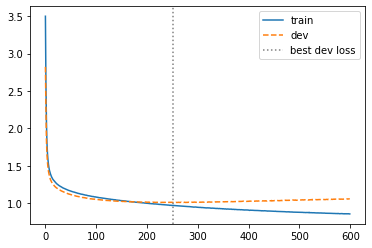

In [14]:
model = train_model()

## Evaluation & metrics
- Run the model on the eval set
- Evaluate the model using perplexity, cross entropy

In [15]:
# reload the model and data if necessary
model_reloaded = NameRNN(vocabulary_size, embedding_size, hidden_size, rnn_layers, dropout_proba)
model_reloaded.load_state_dict(torch.load(checkpoint_file_path, map_location='cpu'))
model_reloaded_gpu = model_reloaded.to(device)

# save the collate function and the data split for later use
with open("dataset.pkl", "rb") as f:
    dataset_dict = pickle.load(f)
    
    # unpack the objects
    dataset = dataset_dict['full']
    train_dataset = dataset_dict['train']
    dev_dataset = dataset_dict['dev']
    eval_dataset = dataset_dict['eval']
    
    # recreate the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=num_workers,
                                 collate_fn=noun_collate, pin_memory=True)
    dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=num_workers,
                                 collate_fn=noun_collate, pin_memory=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size,
                                 shuffle=True, num_workers=num_workers,
                                 collate_fn=noun_collate, pin_memory=True)
    dataset_loaders = {"train": train_dataloader, "dev": dev_dataloader, "eval": eval_dataloader}
        
with open("noun_collate.pkl", "rb") as f:
    noun_collate = pickle.load(f)

In [16]:
total_loss = []
results = []
for i, names in enumerate(dataset_loaders['dev']):
    names = names.to(device)

    # autoencoder forward
    # as we are predicting the next character from the previous one,
    # the input is all but the last character and the output is all but the first character
    out, hidden = model_reloaded_gpu(names[:, :-1])
    loss = criterion(out.reshape(-1, out.size(-1)), names[:, 1:].reshape(-1))
    results.append(torch.max(out, -1)[1])

    total_loss.append(loss.cpu().item())

# for perplexity, we just need to apply the exponential on the cross entropy loss to obtain it, according to 
# https://stackoverflow.com/questions/59209086/calculate-perplexity-in-pytorch
perplexity = math.exp(sum(total_loss)/len(total_loss))
print("Average cross entropy: {}".format(sum(total_loss)/len(total_loss)))
print("Average perplexity: {}".format(perplexity))

Average cross entropy: 1.086506575345993
Average perplexity: 2.963901798118446


### Saving results generated for the eval dataset

In [17]:
evaluation_result_file = "evaluation_outputs"
#torch.save(results, evaluation_result_file.cpu())
print(noun_collate.tensor_to_char(results[0][0], keep_special_tokens=False))
print(noun_collate.tensor_to_char(results[0][0]))

Rutch|aaiuwessengaknnk
Rutch|aaiuwessengaknnk


### Sampling the model

In [18]:
def generate(noun_collate, model):
    last_character = torch.LongTensor([[noun_collate.start_id]]).to(device)
    string = ""
    hidden = model.init_hidden(1).to(device)
    while last_character.item() != noun_collate.end_id and len(string) < 30:
        out, hidden = model.to(device)(last_character.to(device), hidden.to(device))

        last_character = torch.multinomial(torch.softmax(out[0].cpu(), -1), 1)
        last_character_string = noun_collate.tensor_to_char(last_character)
        string += last_character_string

        #print("new char:", last_character, last_character_string)
    return string

In [19]:
[generate(noun_collate, model_reloaded_gpu) for i in range(20)]

['Czecc|kouly<END>',
 'Russian|janziev<END>',
 'Arabic|salib<END>',
 'Russian|toaly<END>',
 'Russian|izerenko<END>',
 'Russian|bakzhin<END>',
 'Russian|chuvin<END>',
 'Arabic|toma<END>',
 'Russian|jortovski<END>',
 'Russian|danyuchenko<END>',
 'Czech|jovandin<END>',
 'English|jutt<END>',
 'Russian|katdenov<END>',
 'Russian|martynaev<END>',
 'Russian|jadydkins<END>',
 'Italian|totelli<END>',
 'English|fair<END>',
 'Arabic|kathani<END>',
 'Scotdish|lacklidd<END>',
 'Dutch|schromendege<END>']

In [20]:
print(noun_collate.tensor_to_char(noun_collate.char_to_tensor("ab")))

<START>ab<END>


In [21]:
!jupyter nbconvert esteban_sophea_experiment.ipynb --to html

[NbConvertApp] Converting notebook esteban_sophea_experiment.ipynb to html
[NbConvertApp] Writing 412104 bytes to esteban_sophea_experiment.html
